<a href="https://colab.research.google.com/github/shane-keating/swot/blob/master/AUSWOT_tutorial_AMOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUSWOT tutorial: A SWOT data primer

This tutorial will introduce you to some sample SWOT data and show you how to download data and perform some basic data wrangling tasks. 

## Learning outcomes
- Introduce SWOT sample data products
- Introduce and register for the NASA Earthdata server
- Show you how to find and visualize SWOT data sets on the Earthdata
- Download SWOT KaRIn (2D swath) and nadir (along-track) altimetry data directly to Google Colab
- Explore and merge Xarray datasets
- Swath and nadir plotting

This tutorial has been shamelessly adapted from tutorials developed by NASA PO.DAAC. All kudos to them. 

## Google Colaboratory

We will run this tutorial in [Google Colaboratory](colab.research.google.com). Google Colab is a web-based computational environment in which you can read, write, and execute interactive *notebooks* like the one you are reading. The python code runs on a virtual machine in the cloud, so you don't need to install python on your local machine. 

Before you begin the lab, you might like to [sign up](https://accounts.google.com/signup) for a free Google account. If you do not wish to sign up for a Google account, that's fine: you will still be able to run the lab in "sandbox" mode. You just won't be able save any changes you make. 

### Colaboratory and Google Drive

If you have a Google account, you can mount your Google drive within the Colab environment. This is not required to run the lab. But if you would like to save output you can do so by navigating to `drive/'My Drive'` 

```
from google.colab import drive
drive.mount('/content/drive')
!ls drive/'My Drive'
```

If you would like, you can save a copy of this notebook to your local machine or to your Google drive so you can save your output or see any notes you made within the notebook. 

### Initial steps

In this tutorial, we will explore three different SWOT datasets: 

- SWOT Sample Data Products v1.2: A sample dataset of simulated SWOT products available for direct download: https://podaac.jpl.nasa.gov/SWOT?tab=datasets&sections=about%2Bdata

- SWOT simulated Level 2 KaRIn SSH v1 dataset: Simulated KaRIn (2D swath) SSH measurements available on NASA Earthdata. https://podaac.jpl.nasa.gov/announcements/2022-01-31-Release-simulated-SWOT-SSH-version1-datasets

- SWOT simulated Nadir altimetry dataset: Simulated nadir (along-track) SSH measurements available on NASA Earthdata.  https://podaac.jpl.nasa.gov/announcements/2022-01-31-Release-simulated-SWOT-SSH-version1-datasets


The SSH data in these datasets is derived from the GLORYS ocean model and the SWOT simulator, which reproduces the sampling pattern and errors of the future SWOT mission. The second two datasets replicate the data format of the real SWOT data when it is released on Earthdata. In this tutorial, we will focus on the Science orbit (21-day repeat). At the above links you can also find simualted data for the Cal/Val orbit (1-day repeat). 

If you have not already done so, you should first create a (free) Earthdata login: https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/earthdata-login

### Install modules and libraries

Start by installing a couple of modules we will need: `s3fs` and `cartopy`

In [ ]:
! pip install s3fs
! pip install cartopy
! pip uninstall shapely -y
! pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.4 MB/s 
     |████████████████████████████████| 9.1 MB 11.5 MB/s 
     |████████████████████████████████| 140 kB 45.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 132 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |█████████████████████████

Now let's import libraries.

In [ ]:
import s3fs
import requests
import xarray as xr
import pylab as plt
from netrc import netrc
from urllib import request
from platform import system
from getpass import getpass
from http.cookiejar import CookieJar
from os.path import expanduser, join

import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from os import path
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Download the SWOT Sample Data Set

We will begin by downloading the SWOT Sample Data Set directly into Google Colab. The dataset is fairly large (~2.4 Gb) so it may take a few minutes. If downloading a dataset this large is prohibitive, you can skip this section and move to the Earthdata datasets below. 

Note that you will be downloading the dataset to your Google Colab virtual machine, *not* to your local machine. You can also download or upload data to and from your local machine using the folder icon in the toolbar to the left. 

If you have a Google Drive, you can use the instructions described above to connect it to your Google Colab virtual machine and save the data set there (as well as this notebook). 





In [ ]:
! wget https://podaac.jpl.nasa.gov/sites/default/files/content/PODAAC_Documentation/swot_mission_docs/SWOT_sample_data_products_v1.2/L2_LR_SSH.tar.gz

--2022-11-26 23:59:50--  https://podaac.jpl.nasa.gov/sites/default/files/content/PODAAC_Documentation/swot_mission_docs/SWOT_sample_data_products_v1.2/L2_LR_SSH.tar.gz
Resolving podaac.jpl.nasa.gov (podaac.jpl.nasa.gov)... 137.78.248.136
Connecting to podaac.jpl.nasa.gov (podaac.jpl.nasa.gov)|137.78.248.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2560666816 (2.4G) [application/x-gzip]
Saving to: ‘L2_LR_SSH.tar.gz’

L2_LR_SSH.tar.gz    100%[===================>]   2.38G  38.9MB/s    in 65s     

2022-11-27 00:00:55 (37.8 MB/s) - ‘L2_LR_SSH.tar.gz’ saved [2560666816/2560666816]



If you click on the folder icon to the left you will see a zipped directory called `L2_LR_SSH.tar.gz` sitting in your Google virtual machine. We can unzip this folder using the following command: 

In [ ]:
!tar -xzvf L2_LR_SSH.tar.gz

._L2_LR_SSH
L2_LR_SSH/
L2_LR_SSH/._SWOT_L2_LR_SSH_Expert_001_001_20160901T000000_20160901T005126_DG10_01.nc
L2_LR_SSH/SWOT_L2_LR_SSH_Expert_001_001_20160901T000000_20160901T005126_DG10_01.nc
L2_LR_SSH/._SWOT_L2_LR_SSH_Expert_001_004_20160901T023420_20160901T032546_DG10_01.nc
L2_LR_SSH/SWOT_L2_LR_SSH_Expert_001_004_20160901T023420_20160901T032546_DG10_01.nc
L2_LR_SSH/._SWOT_L2_LR_SSH_Expert_001_008_20160901T060008_20160901T065134_DG10_01.nc
L2_LR_SSH/SWOT_L2_LR_SSH_Expert_001_008_20160901T060008_20160901T065134_DG10_01.nc
L2_LR_SSH/._SWOT_L2_LR_SSH_Unsmoothed_001_005_20160901T032546_20160901T041713_DG10_01.nc
L2_LR_SSH/SWOT_L2_LR_SSH_Unsmoothed_001_005_20160901T032546_20160901T041713_DG10_01.nc
L2_LR_SSH/._SWOT_L2_LR_SSH_Basic_001_004_20160901T023420_20160901T032546_DG10_01.nc
L2_LR_SSH/SWOT_L2_LR_SSH_Basic_001_004_20160901T023420_20160901T032546_DG10_01.nc
L2_LR_SSH/._SWOT_L2_LR_SSH_Basic_001_008_20160901T060008_20160901T065134_DG10_01.nc
L2_LR_SSH/SWOT_L2_LR_SSH_Basic_001_008_20160901

You will now see a new directory called `L2_LR_SSH` containing a large number of netcdf files (`.nc`). These contain a variety of simulated SWOT data products labelled as "Basic", "Wind and Wave", "Expert" and "Unsmoothed". We will be using the "Basic" data products. A full description of the dataset can be found here: https://podaac-tools.jpl.nasa.gov/drive/files/misc/web/misc/swot_mission_docs/pdd/D-56407_SWOT_Product_Description_L2_LR_SSH_20220902_RevA.pdf

Now let's read in one of the files using `xarray` and explore the data variables and attributes contained in the dataset. 

In [ ]:
ds0 = xr.open_dataset('L2_LR_SSH/SWOT_L2_LR_SSH_Basic_001_008_20160901T060008_20160901T065134_DG10_01.nc')
ds0

<xarray.Dataset>
Dimensions:                                (num_lines: 9866, num_pixels: 71, num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/20)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ssh_karin_2                            (num_lines, num_pixels) float64 ...
    ...                                     ...
    rad_surface_type_flag                  (num_lines, num_sides) float32 ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
Attributes: (12/36)
    Conventions:                        CF-1.7
    title:                              Level 2 Low Rate Sea Surface Height D...
    institution:                        CNES/JPL
    source:                             Simulate product
    history:                            2021-01-31 14:03:36 : Creation
    platform:                           SWOT
    ...                                 ...
    xref_input_dynamic_geophys_files:   N/A
    xref_input_l1_nalt_gdr_files:       N/A
    xref_input_int_lr_xover_cal_files:  N/A
    xref_input_l2_rad_gdr_files:        N/A
    ellipsoid_semi_major_axis:          6378137.0
    ellipsoid_flattening:               0.003352810664781205

### Visualize the data

The pass we have imported contains the Bass Strait and Southern Ocean regions. Let's visualize some of the KaRIn data in these region using `cartopy`. 

Adapt this code to visualize other variables or regions, or try importing another file. 

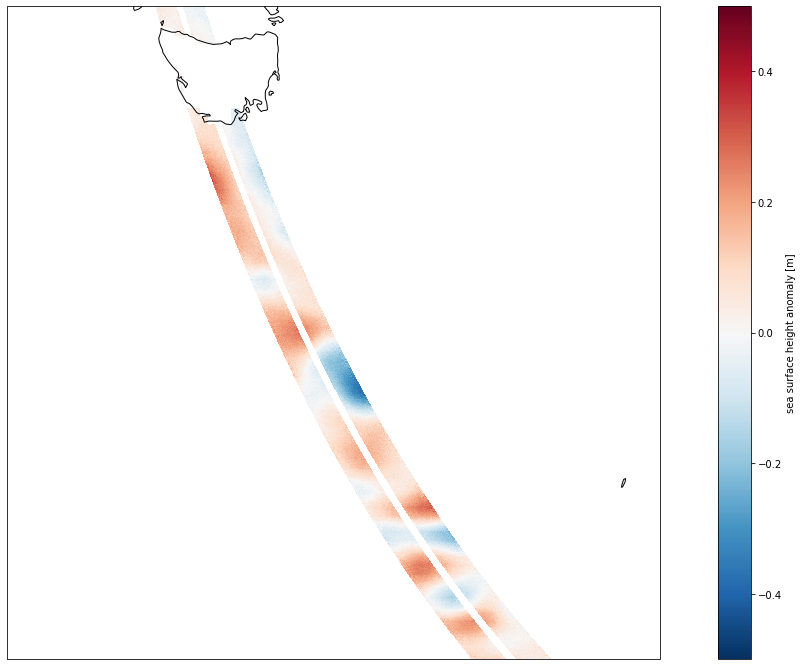

In [ ]:
lolabox = [140, 160, -60, -40  ] # Southern Ocean
#lolabox = [143, 147, -42, -38] # Bass strait region

plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(lolabox)
ds0.ssha_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=True
)
ax.coastlines()

### Data discovery on Earthdata

The data we have examined so far is a small sample set that you can use to play around with SWOT data. However, real SWOT data will not be available in this form. In the next part of the tutorial, we will introduce [Earthdata](https://www.earthdata.nasa.gov/), which is the gateway to NASA Earth Science Data, including the Physical Oceanography Distributed Active Archive Centre, or [PO.DAAC](https://podaac.jpl.nasa.gov/). 

Earthdata has a number of datasets and products that replicate future SWOT data as well as high-resolution numerical model output for pre-launch and post-launch calibration and validation activities. 

Let's start by exploring some tools for data discovery on Earthdata. You will need an [Earthdata login](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/earthdata-login) to do this part of the tutorial. 

- Method 1: [Earthdata Search](https://search.earthdata.nasa.gov/search)
- Method 2: [HiTIDE interactive data extraction](https://hitide.podaac.earthdatacloud.nasa.gov/)


### Importing data from PO.DAAC and Earthdata

Now let's see how you can import data from Earthdata directly into Colab. First you need to connect with Earthdata and provide your Earthdata credentials (username and password). 

In [ ]:
def setup_earthdata_login_auth(endpoint: str='urs.earthdata.nasa.gov'):
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        print('Please provide your Earthdata Login credentials for access.')
        print('Your info will only be passed to %s and will not be exposed in Jupyter.' % (endpoint))
        username = input('Username: ')
        password = getpass('Password: ')
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    
setup_earthdata_login_auth()

Please provide your Earthdata Login credentials for access.
Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.
Username: s.keating
Password: ··········


In this demo, we use SWOT Simulated Level-2 KaRIn SSH from GLORYS for Science Version 1. More information on the datasets can be found at https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1. 

From the Earthdata search, we identify the shortname for the dataset we are interested in and a series of filenames that we want to download. 

In [ ]:
ShortName = "SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_SCIENCE_V1"

remote_files = ['SWOT_L2_LR_SSH_Expert_001_001_20140412T120000_20140412T125126_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_002_20140412T125126_20140412T134253_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_003_20140412T134253_20140412T143420_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_004_20140412T143420_20140412T152546_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_005_20140412T152547_20140412T161713_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_006_20140412T161714_20140412T170840_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_007_20140412T170840_20140412T180007_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_008_20140412T180008_20140412T185134_DG10_01.nc',
 'SWOT_L2_LR_SSH_Expert_001_009_20140412T185134_20140412T194301_DG10_01.nc']

Now we download the remote files one-by-one into our Colab directory and then concatenate them into a single xarray dataset. The resulting dataset has much more "Expert" level information such as estimated errors calculated using the SWOT simulator. 

In [ ]:
# Download files to virtual machine
for target_file in remote_files:
  print(target_file)
  https_access = f"https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/{ShortName}/{target_file}"
  request.urlretrieve(https_access, target_file)

# Load netCDF with 'xarray' after download completes
ds1 = xr.open_mfdataset("SWOT_L2_LR_SSH_Expert_001_0*.nc", combine='nested', concat_dim="num_lines", decode_times=False)

# Look at the dataset
ds1

SWOT_L2_LR_SSH_Expert_001_001_20140412T120000_20140412T125126_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_002_20140412T125126_20140412T134253_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_003_20140412T134253_20140412T143420_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_004_20140412T143420_20140412T152546_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_005_20140412T152547_20140412T161713_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_006_20140412T161714_20140412T170840_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_007_20140412T170840_20140412T180007_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_008_20140412T180008_20140412T185134_DG10_01.nc
SWOT_L2_LR_SSH_Expert_001_009_20140412T185134_20140412T194301_DG10_01.nc


<xarray.Dataset>
Dimensions:                                (num_lines: 88796, num_pixels: 71, num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/91)
    time                                   (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) float64 dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float32 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    ...                                     ...
    simulated_error_baseline_dilation      (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_timing                 (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_roll                   (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_phase                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_orbital                (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
    simulated_error_karin                  (num_lines, num_pixels) float64 dask.array<chunksize=(9866, 71), meta=np.ndarray>
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-10 09:54:55Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       131.81928697472432
    right_last_latitude:        77.03254381435897
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.003352810664781205

Let's visualize the data on a global map. Notice that we have concatenated several passes into a single dataset. 

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarnin

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


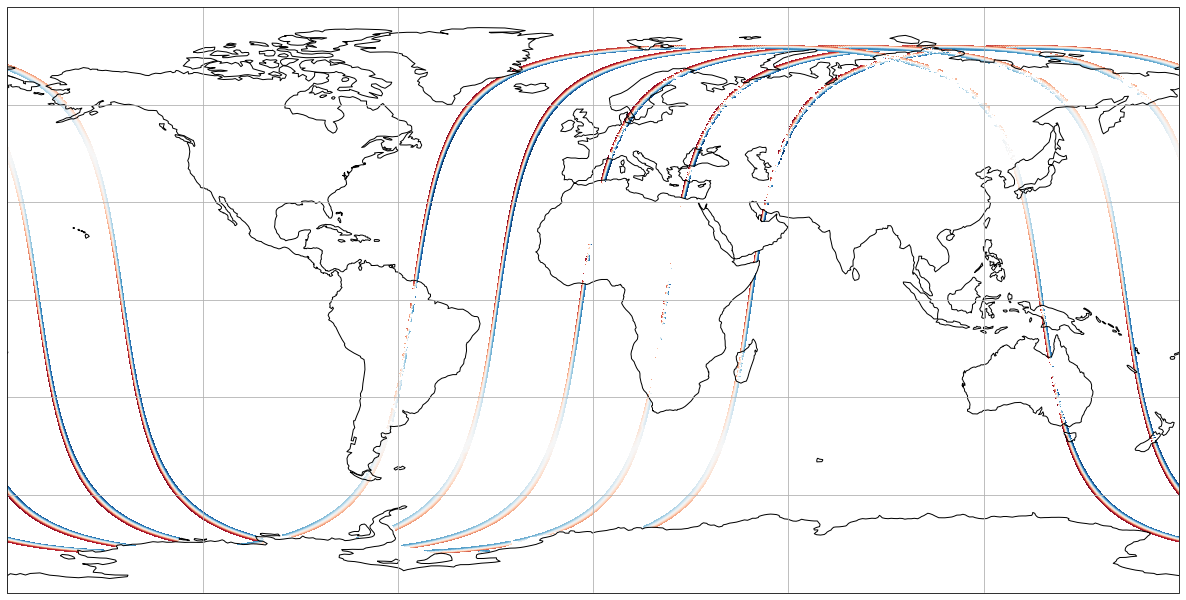

In [ ]:
plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds1.ssha_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=False
)
ax.coastlines()
ax.gridlines()

Let's zoom in on the Bass Strait region and visualize the errors. 

The errors look cool, but if we do the same thing for the SSH anomaly, the result looks strange. I don't know why it looks this way. 

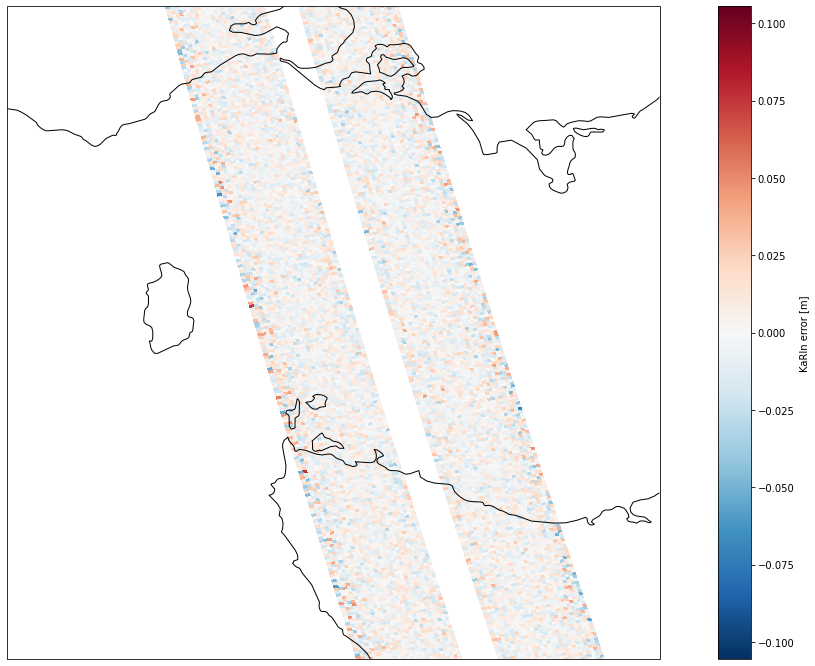

In [ ]:
lolabox = [143, 147, -42, -38] # Bass Strait
plt.figure(figsize=(21, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(lolabox)
ds1.simulated_error_karin.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", add_colorbar=True
)
ax.coastlines()

### Importing Nadir data

So far we have looked at simulated 2D swath data from the KaRIn instrument on SWOT. SWOT also carries a traditional nadir (downward-looking) altimeter that measures sea surface height directly below the satellite. This is stored in a different dataset. 

Download the nadir data from the Earthdata server. 

In [ ]:
ShortName = "SWOT_SIMULATED_L2_NADIR_SSH_GLORYS_SCIENCE_V1"
target_file = 'SWOT_GPR_2PTP001_008_20140412_180008_20140412_185134.nc'

print(target_file)
https_access = f"https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/{ShortName}/{target_file}"
request.urlretrieve(https_access, target_file)

Import the data into an xarray dataset. Note that the netcdf files have data in two separate "Groups". We will merge these groups into a single xarray dataset. 

In [ ]:
dsA = xr.open_dataset(target_file,group="/data_01/ku")
dsB = xr.open_dataset(target_file,group="/data_01/")

ds2 = xr.Dataset.merge(dsA,dsB)
ds2

<xarray.Dataset>
Dimensions:                            (time: 3036)
Coordinates:
  * time                               (time) datetime64[ns] 2014-04-12T18:00...
    latitude                           (time) float64 ...
    longitude                          (time) float64 ...
Data variables: (12/47)
    range_ocean                        (time) float64 ...
    range_ocean_mle3                   (time) float64 ...
    iono_cor_alt_filtered              (time) float32 ...
    iono_cor_alt_filtered_mle3         (time) float32 ...
    sea_state_bias                     (time) float32 ...
    sea_state_bias_mle3                (time) float32 ...
    ...                                 ...
    pole_tide                          (time) float32 ...
    internal_tide                      (time) float32 ...
    wind_speed_alt                     (time) float32 ...
    wind_speed_alt_mle3                (time) float32 ...
    rad_water_vapor                    (time) float32 ...
    rad_cloud_liquid_water             (time) float32 ...

### Visualising nadir data

Data from the nadir instrument can be plotted against time, latitude, or longitude. Let's do this with the measured SSH and the "true" SSH (i.e. from the model). Switching between visualizations causes the plots to stretch or shrink in different places because of the satellite orbit. 

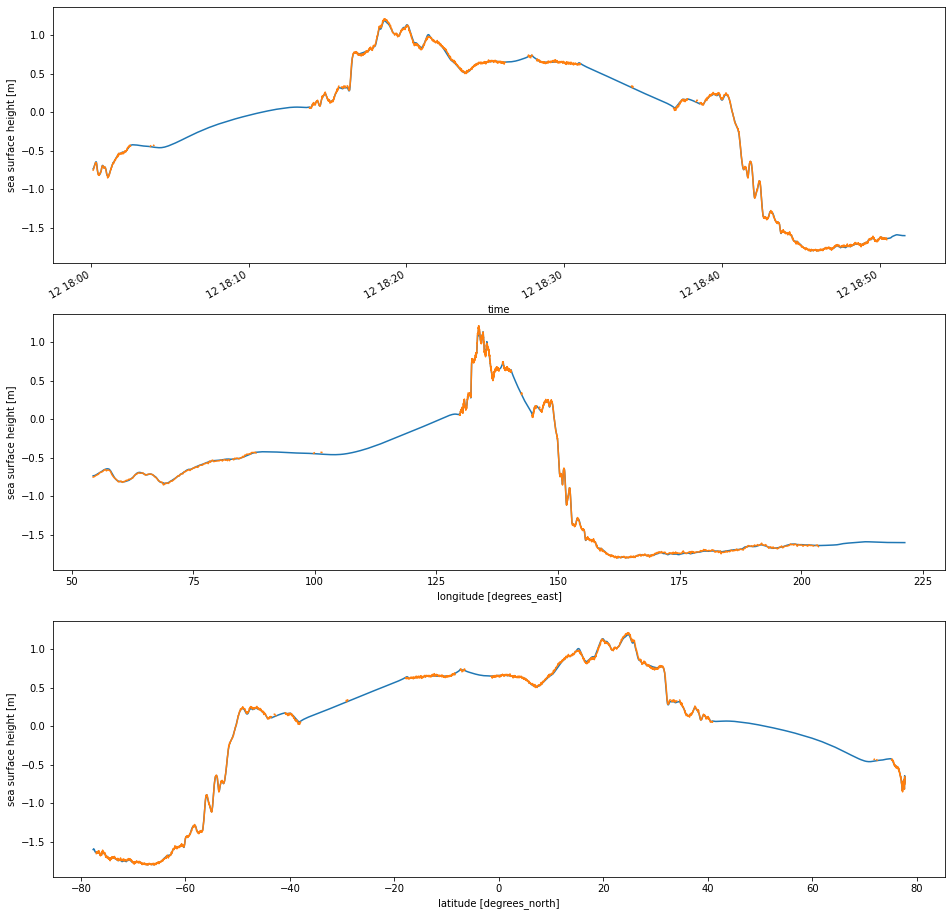

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.subplot(3,1,1)
ds2.simulated_true_ssh.plot(x="time")
ds2.ssh.plot(x="time")

plt.subplot(3,1,2)
ds2.simulated_true_ssh.plot(x="longitude")
ds2.ssh.plot(x="longitude")

plt.subplot(3,1,3)
ds2.simulated_true_ssh.plot(x="latitude")
ds2.ssh.plot(x="latitude")

Now let's zoom in on the Bass strait region again. We can limit our plots based on the longitude and latitude box we used for the Bass Strait region. 

(-42.0, -38.0)

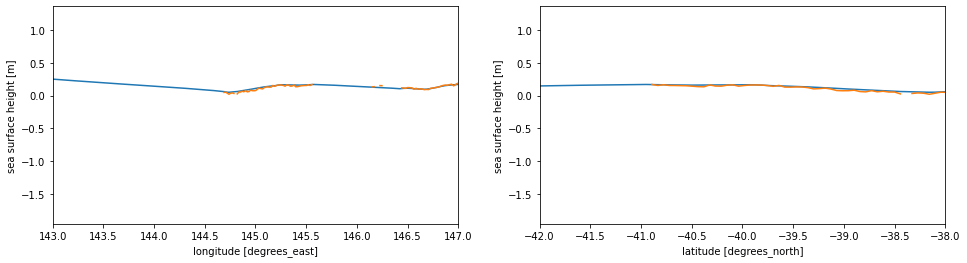

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))

p1 = plt.subplot(1,2,1)
ds2.simulated_true_ssh.plot(x="longitude")
ds2.ssh.plot(x="longitude")
p1.set_xlim(lolabox[0],lolabox[1])

p2 = plt.subplot(1,2,2)
ds2.simulated_true_ssh.plot(x="latitude")
ds2.ssh.plot(x="latitude")
p2.set_xlim(lolabox[2],lolabox[3])